### Clusterização e Redução de Dimensionalidade

1. Introdução:
Explicação sobre o que é clusterização e sua importância.
Explicação sobre o que é redução de dimensionalidade e sua importância.


2. Clusterização com K-means:
Explicação do algoritmo K-means.
Aplicação do K-means no conjunto de dados (talvez usando latitude e longitude para identificar grupos de voos com base na localização).


3. Escolhendo o número de clusters - Método do Cotovelo (Elbow Method):
Explicação sobre a técnica do Elbow Method.
Aplicação no conjunto de dados para determinar o número ideal de clusters.


4. Clusterização com DBSCAN e HDBSCAN:
Explicação sobre o algoritmo DBSCAN e suas vantagens/desvantagens em relação ao K-means.
Aplicação do DBSCAN no conjunto de dados.
Explicação sobre o algoritmo HDBSCAN e como ele melhora o DBSCAN.
Aplicação do HDBSCAN no conjunto de dados.


5. Redução de Dimensionalidade com PCA (Principal Component Analysis):
Explicação sobre o PCA e sua utilidade.
Aplicação do PCA no conjunto de dados e visualização dos resultados.

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Carregar o arquivo CSV
data = pd.read_parquet("../../dados/rotas_aereas/data.parquet")
data = data.dropna()

# Exibir as primeiras linhas do conjunto de dados
data.shape

(1216863, 18)

In [9]:
data.head()

,indicat,time,unix,lat,lon,alt,head,speed,equip,regist,orig,dest,id_iata,id_icao,code1,code2,Distance1,Distance2
1,1.0,2017-09-12 06:07:35-03:00,1.505207e+09,-15.8713,-47.9186,0.0,257.0,0.0,A320,PR-MYT,BSB,CGH,JJ3711,TAM3711,48BE3,0,0.011372,471.550215
2,1.0,2017-09-12 06:08:36-03:00,1.505207e+09,-15.8713,-47.9186,0.0,139.0,0.0,A320,PR-MYT,BSB,CGH,JJ3711,TAM3711,48BE3,0,0.011372,471.550215
3,1.0,2017-09-12 06:09:41-03:00,1.505207e+09,-15.8713,-47.9186,0.0,139.0,0.0,A320,PR-MYT,BSB,CGH,JJ3711,TAM3711,48BE3,0,0.011372,471.550215
4,1.0,2017-09-12 06:10:38-03:00,1.505207e+09,-15.8713,-47.9186,0.0,114.0,0.0,A320,PR-MYT,BSB,CGH,JJ3711,TAM3711,48BE3,0,0.011372,471.550215
5,1.0,2017-09-12 06:11:40-03:00,1.505208e+09,-15.8713,-47.9186,0.0,337.0,0.0,A320,PR-MYT,BSB,CGH,JJ3711,TAM3711,48BE3,0,0.011372,471.550215


In [10]:
data['equip'].unique()

['A320', 'B738', 'B737', 'A319', 'A318', ..., 'B733', 'A321', 'A332', 'AT76', 'B763']
Length: 14
Categories (291, object): ['', 'A20N', 'A318', 'A319', ..., 'ERCO', 'FA20', 'T204', 'CRJ9']

In [11]:
N_VOOS = 150
# select sample indicat unique values from indicat column
voos_unicos = data['indicat'].unique()
sample = np.random.choice(voos_unicos, N_VOOS, replace=False)
data = data[data['indicat'].isin(sample)]

In [12]:
# achar o intervalo de tempo contido no conjunto de dados usando a coluna time
print(data.time.min())
print(data.time.max())

2017-09-12 05:34:12-03:00
2017-11-14 23:47:47-02:00


### 2. Clusterização com K-means:

#### Explicação do algoritmo K-means:
O K-means é um dos algoritmos de clusterização mais populares. Ele funciona da seguinte forma:

1. **Inicialização**: Escolhe-se \( k \) pontos aleatoriamente do conjunto de dados como os centros iniciais dos clusters.
2. **Atribuição**: Cada ponto do conjunto de dados é atribuído ao centro mais próximo.
3. **Atualização**: O centro de cada cluster é recalculado como a média de todos os pontos atribuídos a esse cluster.
4. **Convergência**: Os passos 2 e 3 são repetidos até que os centros dos clusters não mudem significativamente ou até que um número máximo de iterações seja alcançado.

Vamos aplicar o K-means ao conjunto de dados usando a latitude e a longitude.



/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


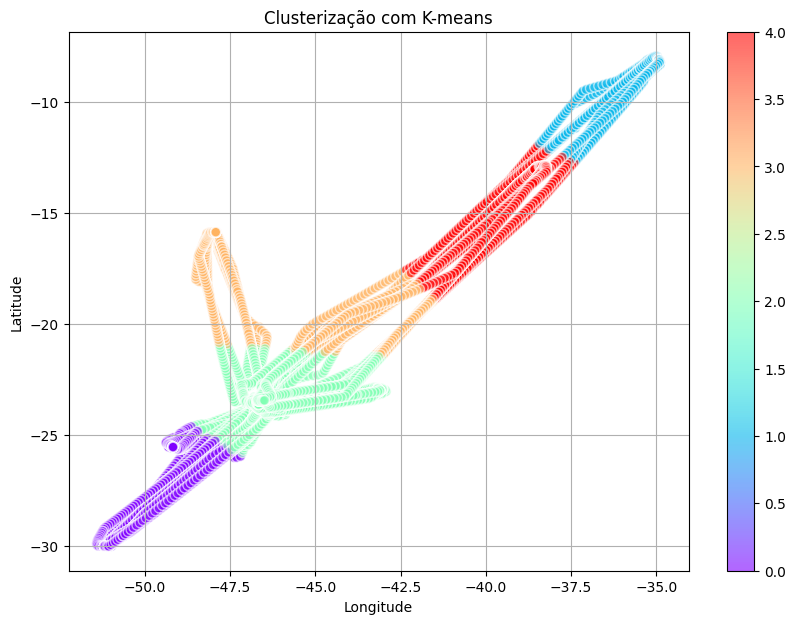

In [13]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt

# Selecionar as colunas 'lat' e 'lon'
X = data[['lat', 'lon']]

# Aplicar o algoritmo K-means com um número arbitrário de clusters (vamos começar com 5)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Adicionar os labels dos clusters ao dataframe
data['kmeans_label'] = kmeans.labels_

# Visualizar os clusters
plt.figure(figsize=(10, 7))
plt.scatter(data['lon'], data['lat'], c=data['kmeans_label'], cmap='rainbow', s=50, alpha=0.6, edgecolors='w')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusterização com K-means')
plt.colorbar()
plt.grid(True)
plt.show()

Como você pode ver no gráfico acima, aplicamos o algoritmo K-means com k = 5 clusters. Os pontos coloridos representam os voos e suas respectivas atribuições de cluster, enquanto os marcadores em forma de 'X' vermelhos representam os centros dos clusters.

No entanto, a escolha de \( k = 5 \) foi arbitrária. Uma questão importante é: como determinamos o número ótimo de clusters? Uma técnica popular para isso é o Método do Cotovelo (Elbow Method), que vamos discutir a seguir.

### 3. Escolhendo o número de clusters - Método do Cotovelo (Elbow Method):

#### Explicação sobre a técnica do Elbow Method:
O Método do Cotovelo envolve a execução do algoritmo K-means para uma variedade de valores de \( k \) e, em seguida, para cada valor de \( k \), calcular a soma dos quadrados das distâncias de cada ponto ao seu centro de cluster atribuído. À medida que aumentamos \( k \), essa soma dos quadrados diminuirá. No entanto, o benefício de aumentar \( k \) diminuirá à medida que \( k \) aumenta. O valor de \( k \) onde essa diminuição se torna marginal é uma boa estimativa do número verdadeiro de clusters. Isso pode ser visualizado como um gráfico e o ponto onde a mudança se torna marginal (ou onde há um "cotovelo") é considerado um bom valor para \( k \).

Vamos aplicar o Método do Cotovelo ao nosso conjunto de dados para determinar o número ideal de clusters.

/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py

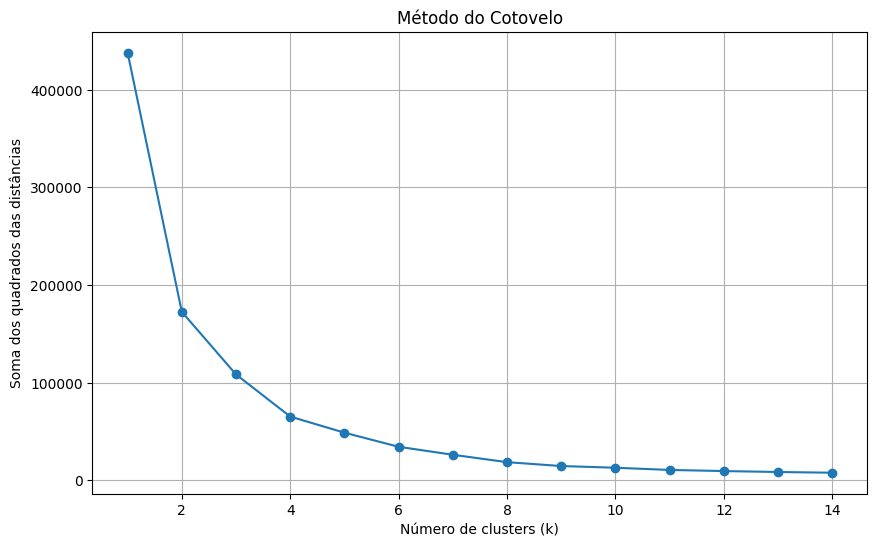

In [14]:
# Calcular a soma dos quadrados das distâncias para uma variedade de valores de k
inertia_values = []
k_values = range(1, 15)

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotar o método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Soma dos quadrados das distâncias")
plt.grid(True)
plt.show()

/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/g9/dlcnl5cd2752fb_17r927ff00000gn/T/ipykernel_2224/2787938652.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origem['kmeans_label']

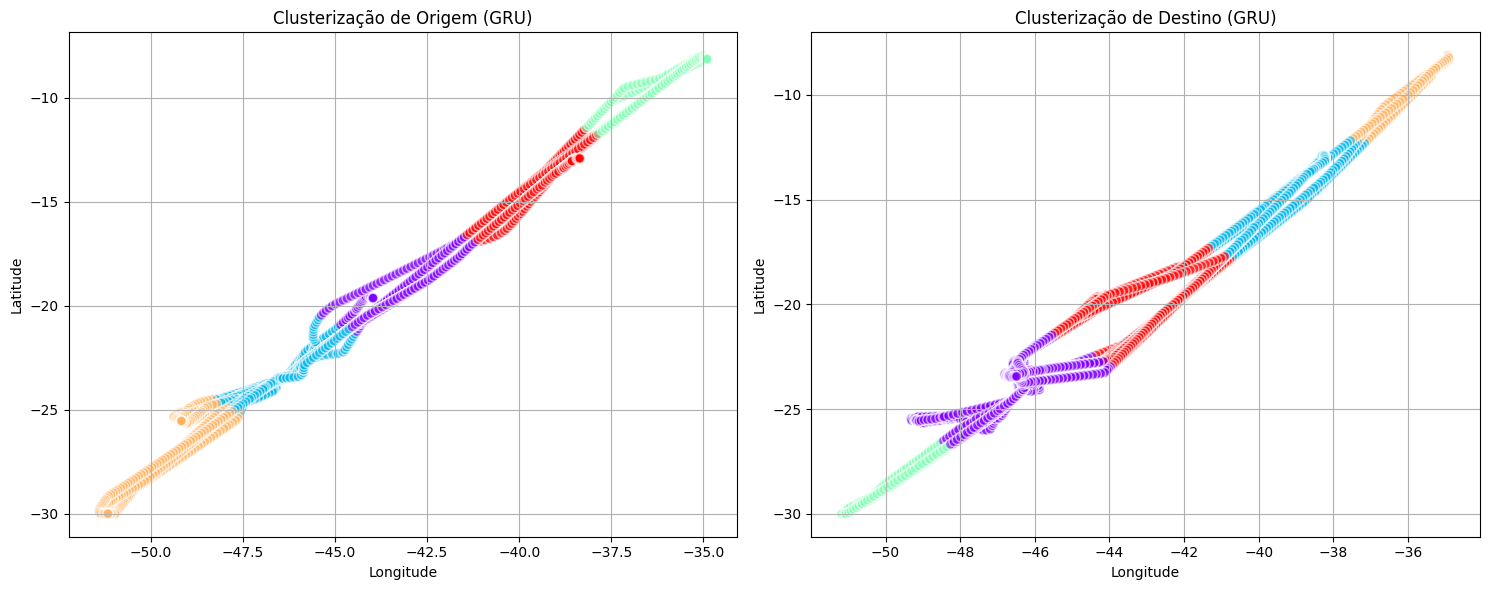

In [15]:
# Filtrar voos por origem e destino
origem = data[data['orig'] == 'GRU']
destino = data[data['dest'] == 'GRU']

# Aplicar o algoritmo K-means para origem e destino
kmeans_origem = KMeans(n_clusters=5, random_state=0).fit(origem[['lat', 'lon']])
kmeans_destino = KMeans(n_clusters=5, random_state=0).fit(destino[['lat', 'lon']])

# Adicionar os labels dos clusters ao dataframe
origem['kmeans_label'] = kmeans_origem.labels_
destino['kmeans_label'] = kmeans_destino.labels_

# Plotar os clusters para origem e destino
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Origem
ax[0].scatter(origem['lon'], origem['lat'], c=origem['kmeans_label'], cmap='rainbow', s=50, alpha=0.6, edgecolors='w')
ax[0].set_title('Clusterização de Origem (GRU)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].grid(True)

# Destino
ax[1].scatter(destino['lon'], destino['lat'], c=destino['kmeans_label'], cmap='rainbow', s=50, alpha=0.6, edgecolors='w')
ax[1].set_title('Clusterização de Destino (GRU)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].grid(True)

plt.tight_layout()
plt.show()


### Teremos que transformar os dados para conseguir trabalhar com trajetórias

In [18]:
# Organizar dados por tempo e id
data_sorted = data.sort_values(by=['indicat', 'unix'])

# Listar trajetórias e seus atributos
trajectories = data_sorted.groupby('indicat').apply(lambda group: group[['lat', 'lon', 'alt', 'head', 'speed']].values)

# Converter o resultado em arrays numpy
trajectories_list = [trajectory for trajectory in trajectories]

In [31]:
# Utilizaremos o algoritmo de Dynamic Time Warping (DTW) para calcular a distância entre as séries temporais
# utilizaremos a implementação do pacote fastdtw
# pip install fastdtw
# https://www.semanticscholar.org/paper/FastDTW%3A-Toward-Accurate-Dynamic-Time-Warping-in-Salvador-Chan/05a20cde15e172fc82f32774dd0cf4fe5827cad2
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Get upper triangle indices
rows, cols = np.triu_indices(trajectories.shape[0], k=1)  # k=1 excludes the main diagonal

In [32]:
# Calculate DTW distances for the upper triangle
distances = [fastdtw(trajectories_list[i], trajectories_list[j], dist=euclidean)[0] for i, j in zip(rows, cols)]

# Fill the distance matrix using the calculated distances
distance_matrix_optimized = np.zeros((trajectories.shape[0], trajectories.shape[0]))
distance_matrix_optimized[rows, cols] = distances
distance_matrix_optimized[cols, rows] = distances  # Reflect the upper triangle to the lower triangle

/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kme

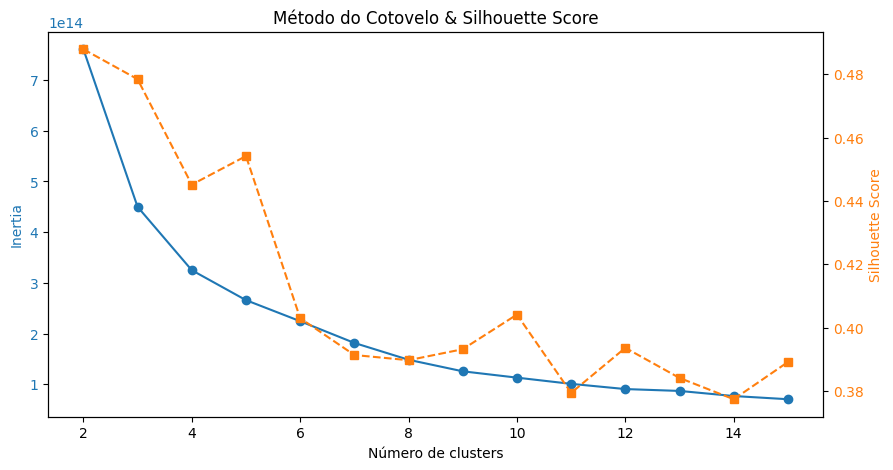

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. KMeans & Elbow Method
# Determine the optimal number of clusters using the Elbow method and silhouette score
max_clusters = 15
inertias = []
silhouettes = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(distance_matrix_optimized)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(distance_matrix_optimized, kmeans.labels_))

# Plotting the Elbow method graph
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Número de clusters')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(range(2, max_clusters + 1), inertias, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.plot(range(2, max_clusters + 1), silhouettes, marker='s', linestyle='--', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Método do Cotovelo & Silhouette Score')
plt.show()

In [36]:
from sklearn.cluster import DBSCAN

# 2. Apply DBSCAN
# Note: For DBSCAN, we'll use the precomputed metric as we already have a distance matrix
dbscan_labels = DBSCAN(metric='precomputed', eps=200000, min_samples=2).fit_predict(distance_matrix_optimized)

# 3. Apply HDBSCAN
# Note: We'll need to use the original implementation of HDBSCAN as it supports precomputed distance matrices
try:
    import hdbscan
    hdbscan_labels = hdbscan.HDBSCAN(metric='precomputed', alpha=0.001).fit_predict(distance_matrix_optimized)
except ImportError:
    hdbscan_labels = None
    print("HDBSCAN is not available in this environment.")

# Using KMeans with 5 clusters as an example from the elbow method results
kmeans = KMeans(n_clusters=5, random_state=42).fit(distance_matrix_optimized)


/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


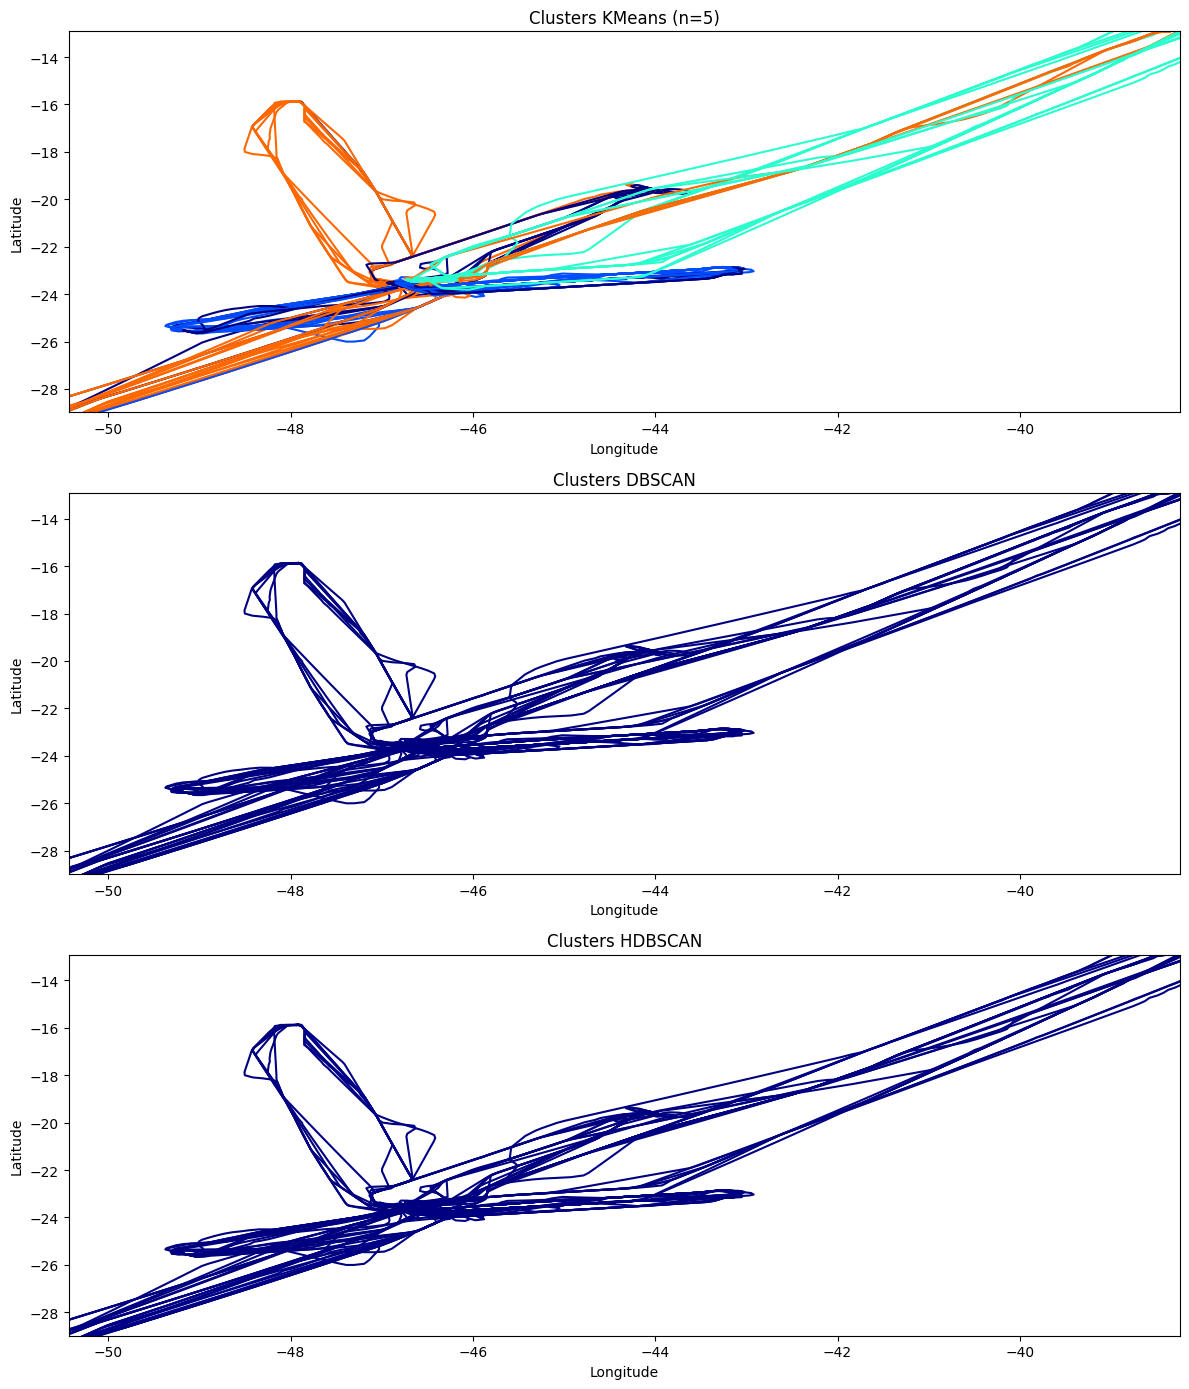

In [37]:
# Determine the latitude and longitude bounds for a focused view
latitudes = [point[0] for trajectory in trajectories for point in trajectory]
longitudes = [point[1] for trajectory in trajectories for point in trajectory]

# Get the 5th and 95th percentiles for latitude and longitude to focus on the main region
lat_min, lat_max = np.percentile(latitudes, [5, 95])
lon_min, lon_max = np.percentile(longitudes, [5, 95])

# Plot the trajectories for KMeans and DBSCAN results
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# KMeans
for j, trajectory in enumerate(trajectories):
    axes[0].plot(trajectory[:, 1], trajectory[:, 0], label=f"Cluster {kmeans.labels_[j]}", color=plt.cm.jet(kmeans.labels_[j] / 5))
axes[0].set_title(f"Clusters KMeans (n=5)")
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xlim([lon_min, lon_max])
axes[0].set_ylim([lat_min, lat_max])

# DBSCAN
for j, trajectory in enumerate(trajectories):
    axes[1].plot(trajectory[:, 1], trajectory[:, 0], label=f"Cluster {dbscan_labels[j]}", color=plt.cm.jet(dbscan_labels[j]))
axes[1].set_title(f"Clusters DBSCAN")
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_xlim([lon_min, lon_max])
axes[1].set_ylim([lat_min, lat_max])


# HDBSCAN
for j, trajectory in enumerate(trajectories):
    axes[2].plot(trajectory[:, 1], trajectory[:, 0], label=f"Cluster {hdbscan_labels[j]}", color=plt.cm.jet(hdbscan_labels[j]))
axes[2].set_title(f"Clusters HDBSCAN")
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_xlim([lon_min, lon_max])
axes[2].set_ylim([lat_min, lat_max])

plt.tight_layout()
plt.show()

array([ 1,  2,  1,  1,  2,  1,  0,  2,  2,  0,  0,  0,  0,  2, -1,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  2,  0,
        2,  1,  0,  2,  0,  0,  0,  0,  1,  1,  2,  0,  1,  0,  0,  2,  2,
        2,  2,  0, -1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0])